In [2]:
# 1. 导入库和环境设置
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import random

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

# 设置英文字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']
feature_names = ['semantic', 'emotion & sentiment', 'behavior']

# 检查GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("环境设置完成")



使用设备: cuda:0
环境设置完成


In [3]:
# 2. 数据读取和预处理
# 读取数据 - 分别处理四种特征
semantic_features = pd.read_csv("E:/comorbidity/models/multi_features/emb-cn-mentalbert.csv")
emotion_features = pd.read_csv("E:/comorbidity/models/multi_features/emotion_sentiment_results.csv")
# topic_features = pd.read_csv("E:/comorbidity/models/multi_features/doc_topic_6.csv")
social_features = pd.read_csv("E:/comorbidity/models/multi_features/social_results.csv")
y_df = pd.read_excel("E:/comorbidity/models/multi_features/Y.xlsx")
y = y_df.iloc[:, 0].values
print(y)

# 数据对齐
min_samples = min(len(semantic_features), len(emotion_features), len(social_features), len(y_df))
print(f"对齐样本数: {min_samples}")

# 分别标准化每种特征
scaler_semantic = StandardScaler()
scaler_emotion = StandardScaler()
# scaler_topic = StandardScaler()
scaler_social = StandardScaler()

X_semantic = scaler_semantic.fit_transform(semantic_features.iloc[:min_samples].values)
X_emotion = scaler_emotion.fit_transform(emotion_features.iloc[:min_samples].values)
# X_topic = scaler_topic.fit_transform(topic_features.iloc[:min_samples].values)
X_social = scaler_social.fit_transform(social_features.iloc[:min_samples].values)

# 记录特征维度
semantic_dim = X_semantic.shape[1]
emotion_dim = X_emotion.shape[1]
# topic_dim = X_topic.shape[1]
social_dim = X_social.shape[1]
print(f"特征维度 - 语义:{semantic_dim}, 情感:{emotion_dim}, 社交:{social_dim}")

# 标签编码
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y[:min_samples])
print(y_encoded)

print(f"类别数量: {len(label_encoder.classes_)}")
print(f"类别名称: {label_encoder.classes_}")

# 数据预处理 - 确保所有特征使用相同的划分索引
train_idx, test_idx = train_test_split(
    np.arange(len(y_encoded)), test_size=0.2, random_state=42, stratify=y_encoded
)

# 使用相同索引划分所有特征
X_train_semantic = X_semantic[train_idx]
X_test_semantic = X_semantic[test_idx]
X_train_emotion = X_emotion[train_idx]
X_test_emotion = X_emotion[test_idx]
# X_train_topic = X_topic[train_idx]
# X_test_topic = X_topic[test_idx]
X_train_social = X_social[train_idx]
X_test_social = X_social[test_idx]

y_train = y_encoded[train_idx]
y_test = y_encoded[test_idx]

# 进一步划分训练集和验证集
train_idx2, val_idx2 = train_test_split(
    np.arange(len(y_train)), test_size=0.25, random_state=42, stratify=y_train
)

X_val_semantic = X_train_semantic[val_idx2]
X_train_semantic = X_train_semantic[train_idx2]
X_val_emotion = X_train_emotion[val_idx2]
X_train_emotion = X_train_emotion[train_idx2]
# X_val_topic = X_train_topic[val_idx2]
# X_train_topic = X_train_topic[train_idx2]
X_val_social = X_train_social[val_idx2]
X_train_social = X_train_social[train_idx2]

y_val = y_train[val_idx2]
y_train = y_train[train_idx2]

print(f"训练集: {len(X_train_semantic)}, 验证集: {len(X_val_semantic)}, 测试集: {len(X_test_semantic)}")

# 转换为PyTorch张量
X_train_tensors = [
    torch.FloatTensor(X_train_semantic).to(device),
    torch.FloatTensor(X_train_emotion).to(device),
    # torch.FloatTensor(X_train_topic).to(device),
    torch.FloatTensor(X_train_social).to(device)
]
y_train_tensor = torch.LongTensor(y_train).to(device)

X_val_tensors = [
    torch.FloatTensor(X_val_semantic).to(device),
    torch.FloatTensor(X_val_emotion).to(device),
    # torch.FloatTensor(X_val_topic).to(device),
    torch.FloatTensor(X_val_social).to(device)
]
y_val_tensor = torch.LongTensor(y_val).to(device)

X_test_tensors = [
    torch.FloatTensor(X_test_semantic).to(device),
    torch.FloatTensor(X_test_emotion).to(device),
    # torch.FloatTensor(X_test_topic).to(device),
    torch.FloatTensor(X_test_social).to(device)
]
y_test_tensor = torch.LongTensor(y_test).to(device)

# 创建数据加载器
batch_size = 128
train_dataset = TensorDataset(*X_train_tensors, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(*X_val_tensors, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("数据预处理完成")


['抑郁焦虑' '抑郁' '抑郁' ... '焦虑' '其他' '抑郁']
对齐样本数: 95163
特征维度 - 语义:768, 情感:11, 社交:10
[2 1 1 ... 3 0 1]
类别数量: 4
类别名称: ['其他' '抑郁' '抑郁焦虑' '焦虑']
训练集: 57097, 验证集: 19033, 测试集: 19033
数据预处理完成


In [4]:
# 3. 多层特征自适应融合模块
class AdvancedFeatureFusion(nn.Module):
    def __init__(self, semantic_dim=768, emotion_dim=11, social_dim=10, 
                 hidden_dim=128, fusion_dim=256):
        super(AdvancedFeatureFusion, self).__init__()
        
        # 特征对齐层
        self.semantic_align = nn.Sequential(
            nn.Linear(semantic_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.emotion_align = nn.Sequential(
            nn.Linear(emotion_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # self.topic_align = nn.Sequential(
        #     nn.Linear(topic_dim, hidden_dim),
        #     nn.BatchNorm1d(hidden_dim),
        #     nn.ReLU(),
        #     nn.Dropout(0.2)
        # )
        
        self.social_align = nn.Sequential(
            nn.Linear(social_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # 交互注意力机制
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=hidden_dim, 
            num_heads=8, 
            dropout=0.3,
            batch_first=True
        )
        
        # 自适应权重学习
        self.adaptive_weights = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 3),
            nn.Softmax(dim=1)
        )
        
        # 多尺度融合
        self.semantic_emotion_fusion = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.semantic_social_fusion = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.global_fusion = nn.Sequential(
            nn.Linear(3 * hidden_dim, fusion_dim),
            nn.BatchNorm1d(fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        self.final_fusion = nn.Sequential(
            nn.Linear(fusion_dim + 2 * hidden_dim, fusion_dim),
            nn.BatchNorm1d(fusion_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
    def forward(self, semantic_feat, emotion_feat, social_feat):
        # 特征对齐
        semantic_aligned = self.semantic_align(semantic_feat)
        emotion_aligned = self.emotion_align(emotion_feat)
        # topic_aligned = self.topic_align(topic_feat)
        social_aligned = self.social_align(social_feat)
        
        # 交互注意力
        features_seq = torch.stack([semantic_aligned, emotion_aligned, social_aligned], dim=1)
        attn_output, attn_weights = self.cross_attention(features_seq, features_seq, features_seq)
        
        semantic_enhanced = attn_output[:, 0, :]
        emotion_enhanced = attn_output[:, 1, :]
        # topic_enhanced = attn_output[:, 2, :]
        social_enhanced = attn_output[:, 2, :]
        
        # 自适应权重学习
        concat_features = torch.cat([semantic_enhanced, emotion_enhanced, social_enhanced], dim=1)
        adaptive_weights = self.adaptive_weights(concat_features)
        
        # 应用自适应权重
        semantic_weighted = semantic_enhanced * adaptive_weights[:, 0:1]
        emotion_weighted = emotion_enhanced * adaptive_weights[:, 1:2]
        # topic_weighted = topic_enhanced * adaptive_weights[:, 2:3]
        social_weighted = social_enhanced * adaptive_weights[:, 2:3]
        
        # 多尺度融合
        semantic_emotion = self.semantic_emotion_fusion(torch.cat([semantic_weighted, emotion_weighted], dim=1))
        semantic_social = self.semantic_social_fusion(torch.cat([semantic_weighted, social_weighted], dim=1))
        
        # 全局融合
        global_fused = self.global_fusion(torch.cat([semantic_weighted, emotion_weighted, social_weighted], dim=1))
        
        # 最终融合
        final_features = self.final_fusion(torch.cat([global_fused, semantic_emotion, semantic_social], dim=1))
        
        return final_features, adaptive_weights, attn_weights

print("特征融合模块定义完成")


特征融合模块定义完成


In [5]:
# 4. DNN+多层特征自适应融合模型
class DNNWithFusion(nn.Module):
    def __init__(self, semantic_dim=768, emotion_dim=11, social_dim=10,
                 hidden_dim=128, fusion_dim=256, num_classes=4):
        super(DNNWithFusion, self).__init__()
        
        # 特征融合模块
        self.feature_fusion = AdvancedFeatureFusion(
            semantic_dim, emotion_dim, social_dim, 
            hidden_dim, fusion_dim
        )
        
        # DNN分类器
        self.dnn = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.BatchNorm1d(fusion_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(fusion_dim // 2, fusion_dim // 4),
            nn.BatchNorm1d(fusion_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(fusion_dim // 4, num_classes)
        )
        
    def forward(self, semantic_feat, emotion_feat, social_feat):
        # 特征融合
        fused_features, adaptive_weights, attn_weights = self.feature_fusion(
            semantic_feat, emotion_feat, social_feat
        )
        
        # DNN分类
        logits = self.dnn(fused_features)
        
        return logits, adaptive_weights, attn_weights

print("DNN模型定义完成")


DNN模型定义完成


In [6]:
# 5. 训练和评估函数定义
# 设置随机种子函数
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 训练和评估函数
def train_and_evaluate(seed):
    set_random_seed(seed)
    
    # 重新初始化模型
    model = DNNWithFusion(
        semantic_dim=semantic_dim,
        emotion_dim=emotion_dim,
        # topic_dim=topic_dim,
        social_dim=social_dim,
        hidden_dim=hidden_dim,
        fusion_dim=fusion_dim,
        num_classes=num_classes
    ).to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    # 训练历史记录
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    patience = 6
    counter = 0
    best_val_acc = 0.0
    num_epochs = 50
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # 创建进度条
        progress_bar = tqdm(train_loader, desc=f'运行{seed} Epoch {epoch+1:2d}/{num_epochs}')
        
        for batch_data in progress_bar:
            semantic, emotion, social, labels = batch_data
            
            outputs, adaptive_weights, attn_weights = model(semantic, emotion, social)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # 更新进度条
            progress_bar.set_postfix({'Loss': f'{loss.item():.3f}', 'Acc': f'{100.*correct/total:.1f}%'})
        
        progress_bar.close()
        
        # 计算训练指标
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # 验证集评估
        model.eval()
        with torch.no_grad():
            val_outputs, _, _ = model(*X_val_tensors)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_pred = torch.max(val_outputs, 1)
            val_correct = val_pred.eq(y_val_tensor).sum().item()
            val_acc = 100. * val_correct / y_val_tensor.size(0)
        
        # 记录历史
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss.item())
        history['val_acc'].append(val_acc)
        
        # 学习率调度
        scheduler.step(val_loss)
        
        # 早停检查
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), f'best_dnn_fusion_model_{seed}.pth')
        else:
            counter += 1
            if counter >= patience:
                break
    
    # 加载最佳模型
    model.load_state_dict(torch.load(f'best_dnn_fusion_model_{seed}.pth'))
    
    # 测试集评估
    model.eval()
    with torch.no_grad():
        outputs, adaptive_weights, attn_weights = model(*X_test_tensors)
        _, y_pred = torch.max(outputs, 1)
        y_pred_proba = torch.softmax(outputs, dim=1).cpu().numpy()
    
    y_test_np = y_test_tensor.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    # 计算weighted指标
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision = precision_score(y_test_np, y_pred_np, average='weighted')
    recall = recall_score(y_test_np, y_pred_np, average='weighted')
    f1 = f1_score(y_test_np, y_pred_np, average='weighted')
    
    # 计算weighted AUC
    y_test_bin = label_binarize(y_test_np, classes=list(range(num_classes)))
    auc_weighted = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_weighted,
        'history': history,
        'y_pred': y_pred_np,
        'y_pred_proba': y_pred_proba,
        'adaptive_weights': adaptive_weights.cpu().numpy(),
        'seed': seed
    }

print("训练和评估函数定义完成")


训练和评估函数定义完成


In [7]:
# 6. 模型训练执行和统计分析
# 初始化模型参数
hidden_dim = 128
fusion_dim = 256
num_classes = len(label_encoder.classes_)

# 运行10次实验
print("开始10次独立实验...")
results = []
for i in range(10):
    print(f"运行第{i+1}次实验 (seed={42+i})...")
    result = train_and_evaluate(42+i)
    results.append(result)
    print(f"第{i+1}次: 准确率={result['accuracy']:.4f}, F1={result['f1']:.4f}")

# 计算统计结果
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
stats = {}

for metric in metrics:
    values = [r[metric] for r in results]
    stats[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

print("10次实验完成")


开始10次独立实验...
运行第1次实验 (seed=42)...


运行42 Epoch 27/50: 100%|██████████| 447/447 [00:04<00:00, 90.95it/s, Loss=1.101, Acc=90.1%] 


第1次: 准确率=0.8441, F1=0.8404
运行第2次实验 (seed=43)...


运行43 Epoch 38/50: 100%|██████████| 447/447 [00:12<00:00, 36.62it/s, Loss=0.493, Acc=91.7%]


第2次: 准确率=0.8399, F1=0.8379
运行第3次实验 (seed=44)...


运行44 Epoch 36/50: 100%|██████████| 447/447 [00:05<00:00, 87.86it/s, Loss=0.903, Acc=91.1%]


第3次: 准确率=0.8425, F1=0.8404
运行第4次实验 (seed=45)...


运行45 Epoch 34/50: 100%|██████████| 447/447 [00:04<00:00, 95.47it/s, Loss=0.447, Acc=91.1%]


第4次: 准确率=0.8433, F1=0.8398
运行第5次实验 (seed=46)...


运行46 Epoch 28/50: 100%|██████████| 447/447 [00:12<00:00, 37.10it/s, Loss=0.859, Acc=89.9%]


第5次: 准确率=0.8419, F1=0.8389
运行第6次实验 (seed=47)...


运行47 Epoch 28/50: 100%|██████████| 447/447 [00:05<00:00, 83.22it/s, Loss=0.615, Acc=90.3%]


第6次: 准确率=0.8430, F1=0.8398
运行第7次实验 (seed=48)...


运行48 Epoch 27/50: 100%|██████████| 447/447 [00:04<00:00, 93.49it/s, Loss=1.536, Acc=90.1%]


第7次: 准确率=0.8426, F1=0.8396
运行第8次实验 (seed=49)...


运行49 Epoch 36/50: 100%|██████████| 447/447 [00:12<00:00, 36.82it/s, Loss=0.582, Acc=91.4%]


第8次: 准确率=0.8421, F1=0.8389
运行第9次实验 (seed=50)...


运行50 Epoch 15/50: 100%|██████████| 447/447 [00:11<00:00, 40.18it/s, Loss=1.086, Acc=85.9%]


第9次: 准确率=0.8378, F1=0.8339
运行第10次实验 (seed=51)...


运行51 Epoch 18/50: 100%|██████████| 447/447 [00:11<00:00, 39.56it/s, Loss=0.603, Acc=86.6%]


第10次: 准确率=0.8404, F1=0.8371
10次实验完成


In [8]:
# 7. 结果输出和权重分析
# 输出最终结果
print("\n" + "="*50)
print("最终结果 (平均值±标准差)")
print("="*50)
print(f"准确率: {stats['accuracy']['mean']:.4f} ± {stats['accuracy']['std']:.4f}")
print(f"精准率: {stats['precision']['mean']:.4f} ± {stats['precision']['std']:.4f}")
print(f"召回率: {stats['recall']['mean']:.4f} ± {stats['recall']['std']:.4f}")
print(f"F1值: {stats['f1']['mean']:.4f} ± {stats['f1']['std']:.4f}")
print(f"AUC值: {stats['auc']['mean']:.4f} ± {stats['auc']['std']:.4f}")

# 模型稳定性分析
accuracy_cv = stats['accuracy']['std'] / stats['accuracy']['mean']
f1_cv = stats['f1']['std'] / stats['f1']['mean']
print(f"\n模型稳定性分析:")
print(f"准确率变异系数: {accuracy_cv:.4f}")
print(f"F1值变异系数: {f1_cv:.4f}")
print(f"准确率范围: [{stats['accuracy']['mean']-stats['accuracy']['std']:.4f}, {stats['accuracy']['mean']+stats['accuracy']['std']:.4f}]")

# 保存最后一次实验的预测结果用于后续可视化
final_result = results[-1]
y_pred = final_result['y_pred']
y_pred_proba = final_result['y_pred_proba']
adaptive_weights = final_result['adaptive_weights']
y_test = y_test_tensor.cpu().numpy()
history = final_result['history']

# 自适应权重分析
print("\n=== 自适应特征权重分析 ===")
avg_weights = adaptive_weights.mean(axis=0)
feature_names = ['语义特征', '情感特征',  '社交特征']

print("平均特征权重:")
for name, weight in zip(feature_names, avg_weights):
    print(f"  {name}: {weight:.4f} ({weight*100:.1f}%)")

print("特征权重分布统计:")
for i, name in enumerate(feature_names):
    weights_i = adaptive_weights[:, i]
    print(f"  {name}: 均值={weights_i.mean():.4f}, 标准差={weights_i.std():.4f}")



最终结果 (平均值±标准差)
准确率: 0.8418 ± 0.0018
精准率: 0.8384 ± 0.0019
召回率: 0.8418 ± 0.0018
F1值: 0.8387 ± 0.0019
AUC值: 0.9412 ± 0.0010

模型稳定性分析:
准确率变异系数: 0.0021
F1值变异系数: 0.0022
准确率范围: [0.8400, 0.8435]

=== 自适应特征权重分析 ===
平均特征权重:
  语义特征: 0.2909 (29.1%)
  情感特征: 0.3720 (37.2%)
  社交特征: 0.3372 (33.7%)
特征权重分布统计:
  语义特征: 均值=0.2909, 标准差=0.0669
  情感特征: 均值=0.3720, 标准差=0.0849
  社交特征: 均值=0.3372, 标准差=0.0840


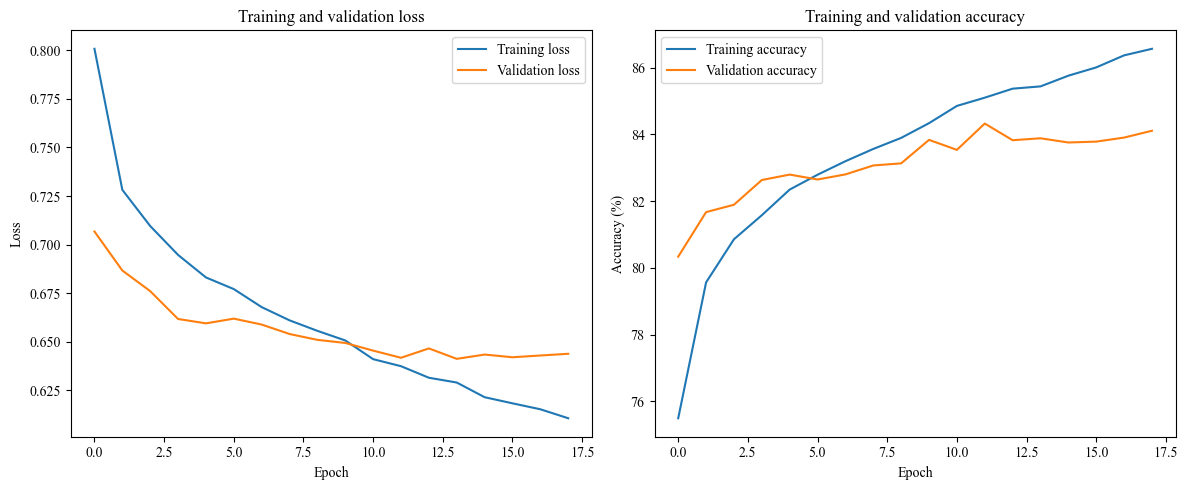

In [9]:
# 设置英文字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 设置英文字体

# 14. 训练历史可视化绘制训练和验证损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Training accuracy')
plt.plot(history['val_acc'], label='Validation accuracy')  # 添加验证准确性曲线
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()


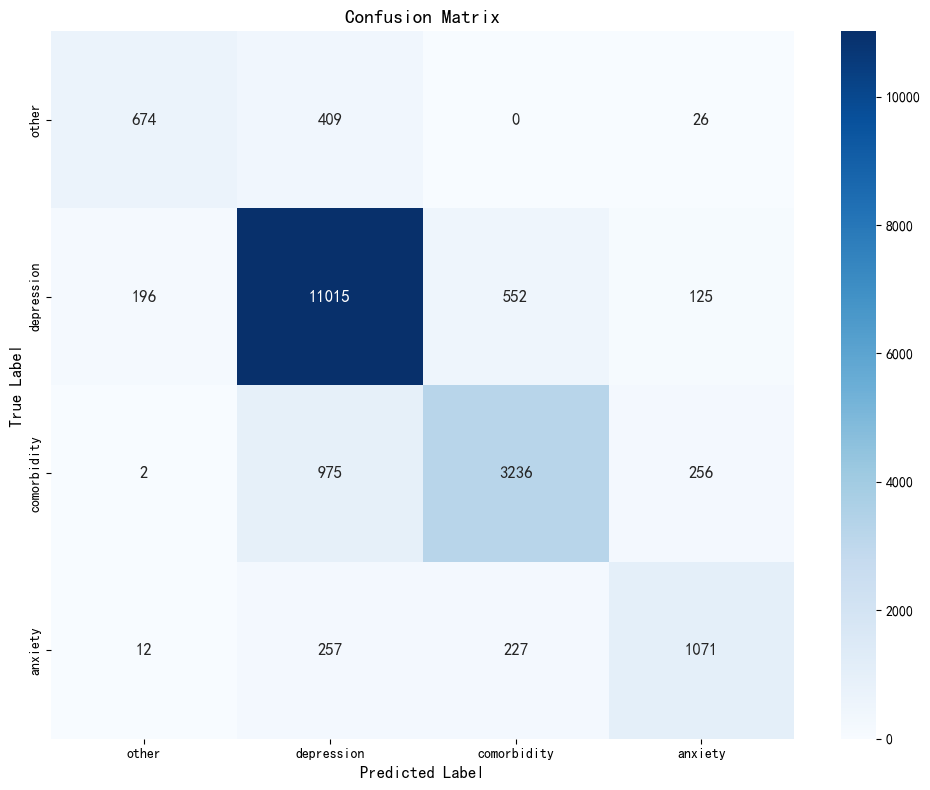

In [10]:
# 混淆矩阵可视化
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC', 'Times New Roman']
conf_matrix = confusion_matrix(y_test, y_pred)

# 定义中英文标签映射
chinese_to_english = {
    '其他': 'other',
    '抑郁': 'depression',
    '焦虑': 'anxiety',
    '抑郁焦虑': 'comorbidity'
}

# 将label_encoder.classes_中的中文标签转换为英文
english_classes = [chinese_to_english.get(cls, cls) for cls in label_encoder.classes_]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=english_classes,  # 使用英文标签
            yticklabels=english_classes,  # 使用英文标签
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

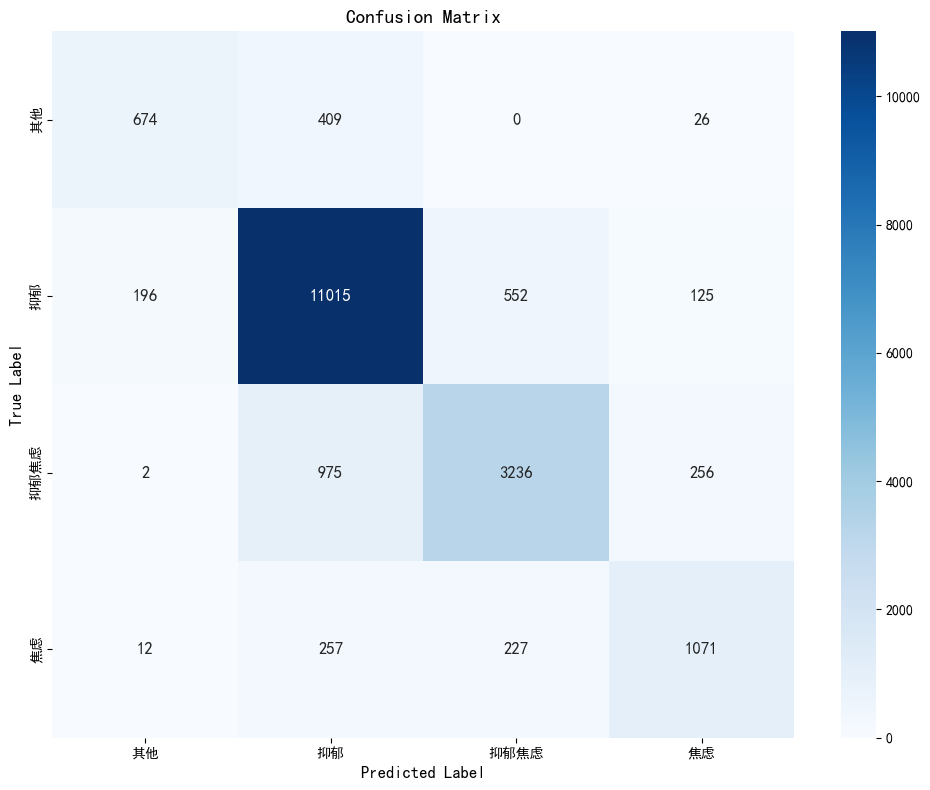

In [11]:

# 混淆矩阵可视化
plt.rcParams['font.sans-serif'] = ['SimHei', 'WenQuanYi Micro Hei', 'Heiti TC','Times New Roman']
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            annot_kws={"size": 12})
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\qy201\AppData\Local\Temp\ipykernel_32696\4080768950.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot([adaptive_weights[:, i] for i in range(3)], labels=feature_names)


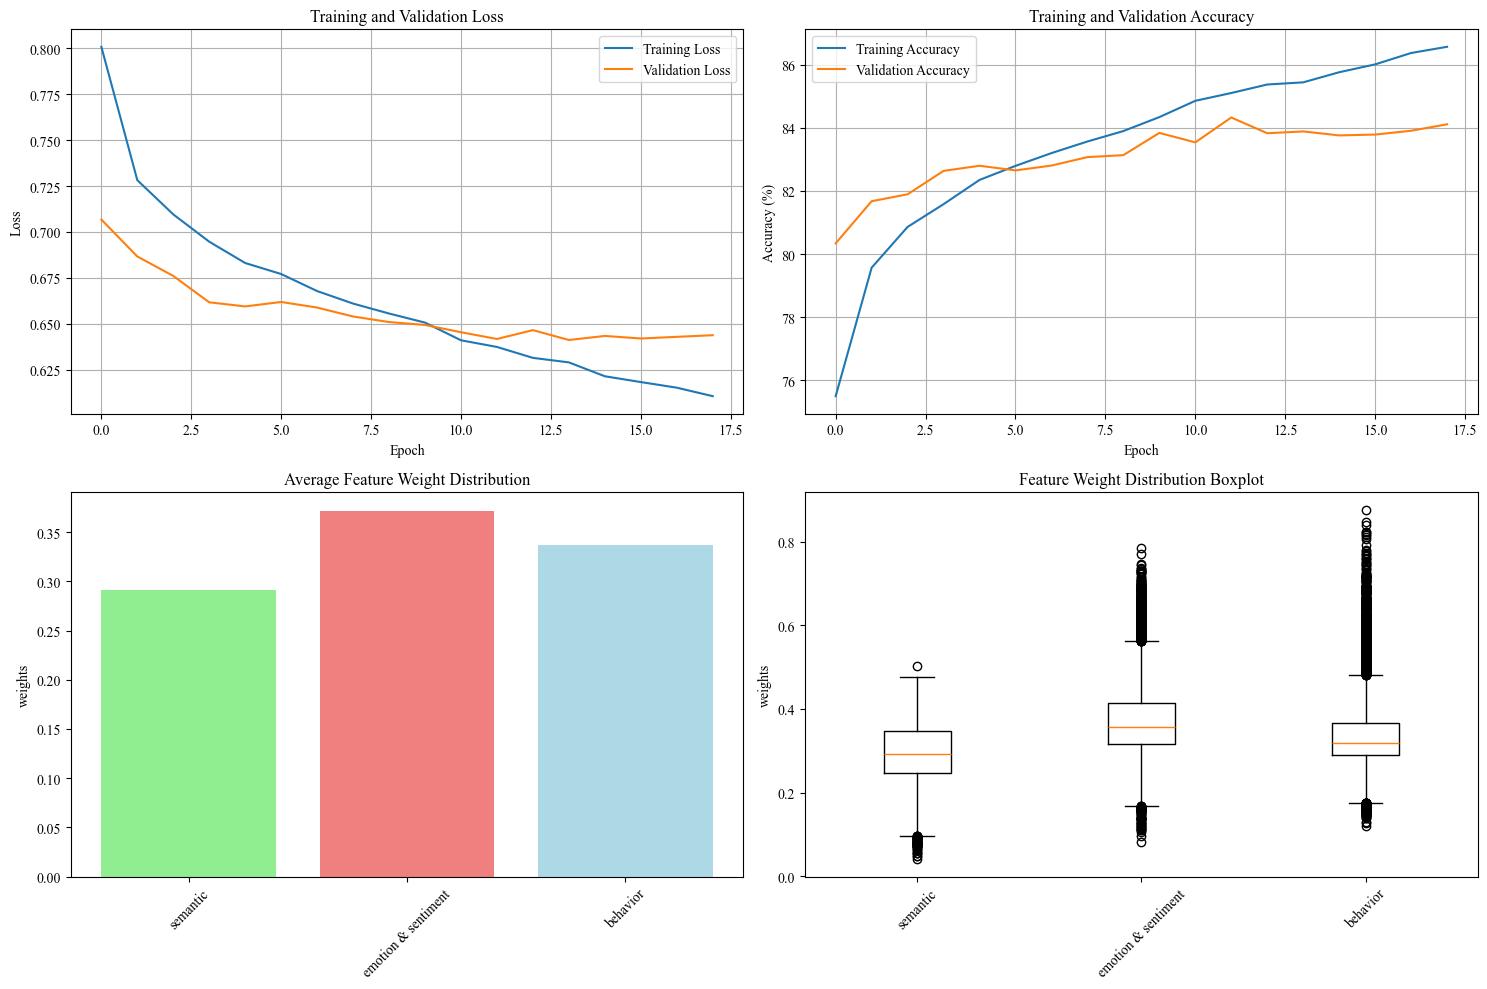

In [12]:
# 8. 训练历史和损失曲线可视化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 设置英文字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 设置英文字体

# 损失曲线
axes[0,0].plot(history['train_loss'], label='Training Loss')
axes[0,0].plot(history['val_loss'], label='Validation Loss')
axes[0,0].set_title('Training and Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# 准确率曲线
axes[0,1].plot(history['train_acc'], label='Training Accuracy')
axes[0,1].plot(history['val_acc'], label='Validation Accuracy')
axes[0,1].set_title('Training and Validation Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy (%)')
axes[0,1].legend()
axes[0,1].grid(True)

# 特征权重分布柱状图
feature_names = ['semantic', 'emotion & sentiment', 'behavior']
avg_weights = adaptive_weights.mean(axis=0)
axes[1,0].bar(feature_names, avg_weights, color=['lightgreen', 'lightcoral', 'lightblue'])
axes[1,0].set_title('Average Feature Weight Distribution')
axes[1,0].set_ylabel('weights')
axes[1,0].tick_params(axis='x', rotation=45)

# 特征权重箱线图
axes[1,1].boxplot([adaptive_weights[:, i] for i in range(3)], labels=feature_names)
axes[1,1].set_title('Feature Weight Distribution Boxplot')
axes[1,1].set_ylabel('weights')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



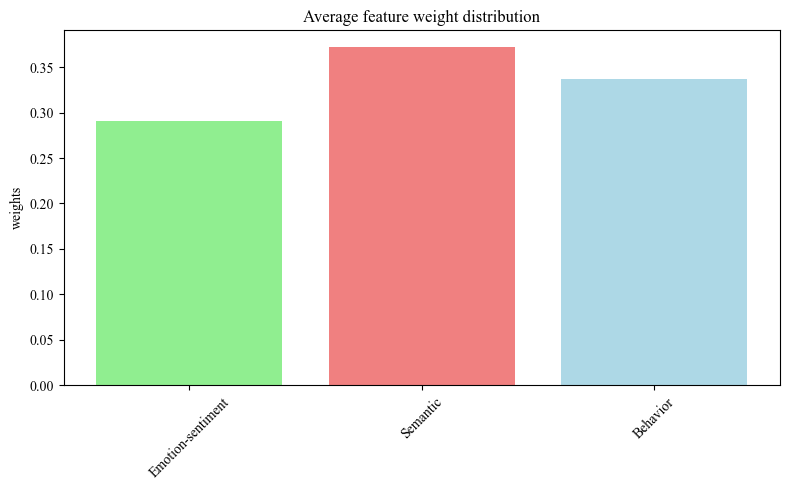

In [13]:
# 9. 特征权重分布柱状图
# 设置英文字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']
feature_names = ['Emotion-sentiment', 'Semantic','Behavior']

# 特征权重分布柱状图
avg_weights = adaptive_weights.mean(axis=0)
plt.figure(figsize=(8, 5))
plt.bar(feature_names, avg_weights, color=['lightgreen', 'lightcoral', 'lightblue'])
plt.title('Average feature weight distribution')
plt.ylabel('weights')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


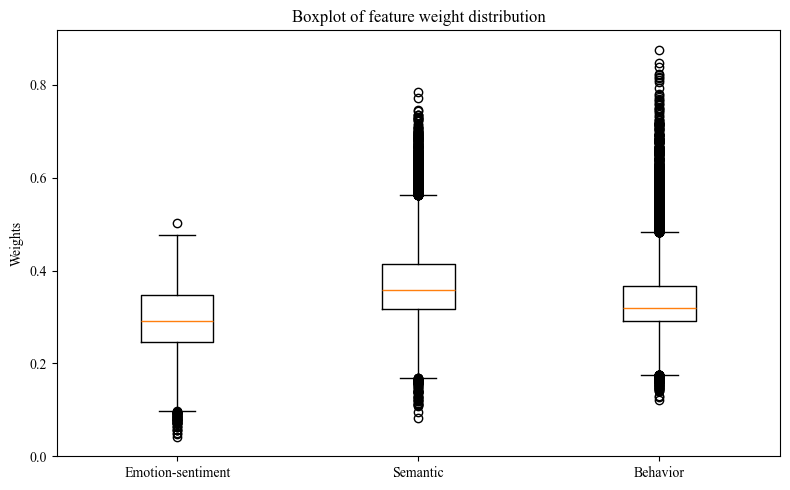

In [14]:
# 10. 特征权重分布箱线图
# 设置英文字体
plt.rcParams['font.sans-serif'] = ['Times New Roman']
feature_names = ['Emotion-sentiment', 'Semantic','Behavior']

# 特征权重箱线图
plt.figure(figsize=(8, 5))
plt.boxplot([adaptive_weights[:, i] for i in range(3)], tick_labels=feature_names)
plt.title('Boxplot of feature weight distribution')
plt.ylabel('Weights')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


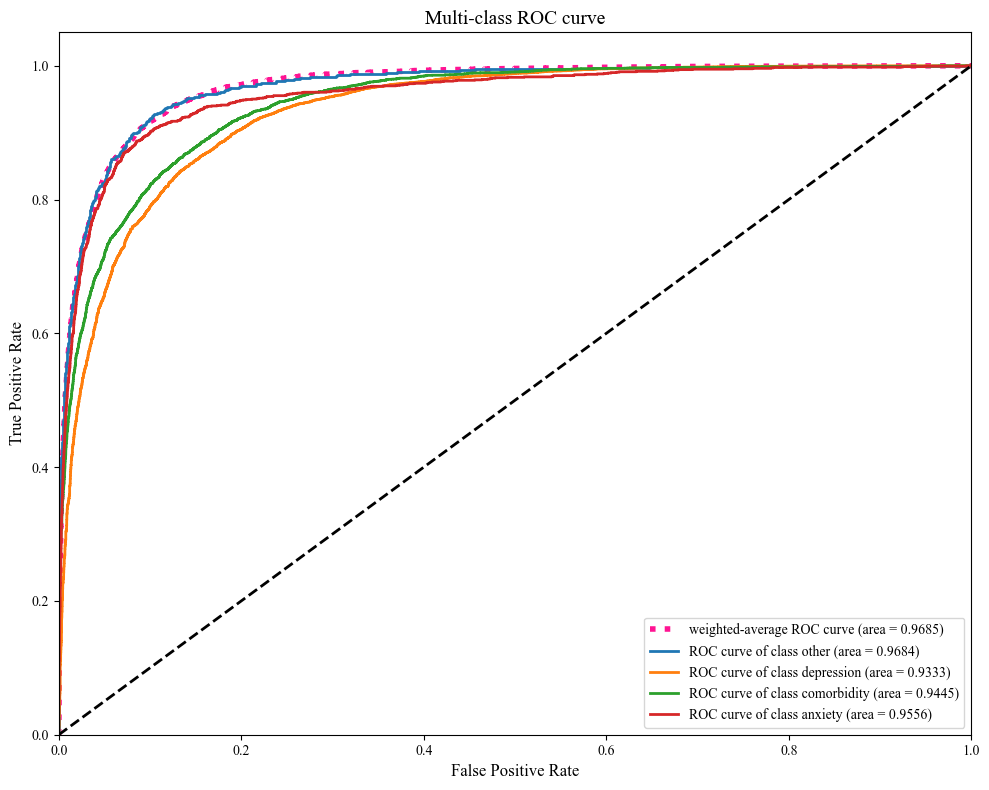

In [15]:
# 多分类ROC曲线可视化
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算微平均ROC曲线和AUC
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

# 定义中英文标签映射
chinese_to_english = {
    '其他': 'other',
    '抑郁': 'depression',
    '焦虑': 'anxiety',
    '抑郁焦虑': 'comorbidity'
}

# 绘制所有类别的ROC曲线
plt.figure(figsize=(10, 8))
plt.plot(fpr["weighted"], tpr["weighted"],
         label='weighted-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["weighted"]),
         color='deeppink', linestyle=':', linewidth=4)

# 使用英文标签替换中文标签
for i in range(n_classes):
    chinese_label = label_encoder.classes_[i]
    english_label = chinese_to_english.get(chinese_label, chinese_label)
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
                   ''.format(english_label, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-class ROC curve', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()